In [1]:
# Shrirang Alias Samarth Patil
# 19BAI10079
# Global Variables 
K = 2 # number of components
query = 'nice good price'

In [2]:
import pandas as pd
import numpy as np

# Data filename
dataset_filename = "../input/Womens Clothing E-Commerce Reviews.csv"

# Loading dataset
data = pd.read_csv(dataset_filename, index_col=0)

# We are reducing the size of our dataset to decrease the running time of code
datax = data.loc[data['Clothing ID'] == 1078 , :]


# Delete missing observations for variables that we will be working with
for x in ["Recommended IND","Review Text"]:
    datax = datax[datax[x].notnull()]

# Keeping only those features that we will explore
datax = datax[["Recommended IND","Review Text"]]

# Resetting the index
datax.index = pd.Series(list(range(datax.shape[0])))
    
print('Shape : ',datax.shape)
datax.head()

Shape :  (987, 2)


,Recommended IND,Review Text
0,0,"I really wanted this to work. alas, it had a s..."
1,1,"I love cute summer dresses and this one, espec..."
2,1,This is the perfect summer dress. it can be dr...
3,1,"Nice fit and flare style, not clingy at all. i..."
4,0,When i first opened this dress and tried it on...


In [3]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

wordnet_lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'[a-z]+')
stop_words = set(stopwords.words('english'))

def preprocess(document):
    document = document.lower() # Convert to lowercase
    words = tokenizer.tokenize(document) # Tokenize
    words = [w for w in words if not w in stop_words] # Removing stopwords
    # Lemmatizing
    for pos in [wordnet.NOUN, wordnet.VERB, wordnet.ADJ, wordnet.ADV]:
        words = [wordnet_lemmatizer.lemmatize(x, pos) for x in words]
    return " ".join(words)

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
datax['Processed Review'] = datax['Review Text'].apply(preprocess)

datax.head()

,Recommended IND,Review Text,Processed Review
0,0,"I really wanted this to work. alas, it had a s...",really want work ala strange fit strap would s...
1,1,"I love cute summer dresses and this one, espec...",love cute summer dress one especially make lin...
2,1,This is the perfect summer dress. it can be dr...,perfect summer dress dress quality linen fabri...
3,1,"Nice fit and flare style, not clingy at all. i...",nice fit flare style clingy get grey color pet...
4,0,When i first opened this dress and tried it on...,first open dress try think adorable flat hourg...


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
TF_IDF_matrix = vectorizer.fit_transform(datax['Processed Review'])
TF_IDF_matrix = TF_IDF_matrix.T

print('Vocabulary Size : ', len(vectorizer.get_feature_names()))
print('Shape of Matrix : ', TF_IDF_matrix.shape)

Vocabulary Size :  2513
Shape of Matrix :  (2513, 987)


In [6]:
import numpy as np

# Applying SVD
U, s, VT = np.linalg.svd(TF_IDF_matrix.toarray()) # .T is used to take transpose and .toarray() is used to convert sparse matrix to normal matrix

TF_IDF_matrix_reduced = np.dot(U[:,:K], np.dot(np.diag(s[:K]), VT[:K, :]))

# Getting document and term representation
terms_rep = np.dot(U[:,:K], np.diag(s[:K])) # M X K matrix where M = Vocabulary Size and N = Number of documents
docs_rep = np.dot(np.diag(s[:K]), VT[:K, :]).T # N x K matrix 

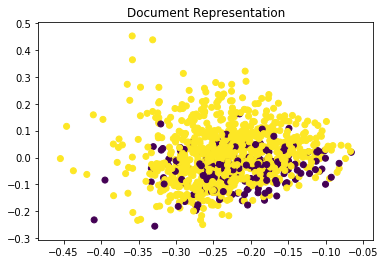

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(docs_rep[:,0], docs_rep[:,1], c=datax['Recommended IND'])
plt.title("Document Representation")
plt.show()

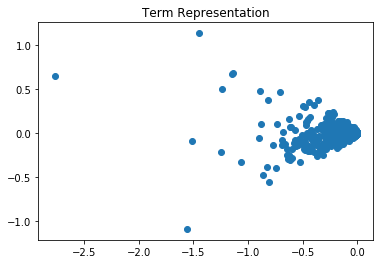

In [8]:
plt.scatter(terms_rep[:,0], terms_rep[:,1])
plt.title("Term Representation")
plt.show()

In [9]:
# This is a function to generate query_rep

def lsa_query_rep(query):
    query_rep = [vectorizer.vocabulary_[x] for x in preprocess(query).split()]
    query_rep = np.mean(terms_rep[query_rep],axis=0)
    return query_rep

In [10]:
from scipy.spatial.distance import cosine

query_rep = lsa_query_rep(query)

query_doc_cos_dist = [cosine(query_rep, doc_rep) for doc_rep in docs_rep]
query_doc_sort_index = np.argsort(np.array(query_doc_cos_dist))

print_count = 0
for rank, sort_index in enumerate(query_doc_sort_index):
    print ('Rank : ', rank, ' Consine : ', 1 - query_doc_cos_dist[sort_index],' Review : ', datax['Review Text'][sort_index])
    if print_count == 4 :
        break
    else:
        print_count += 1

Rank :  0  Consine :  0.9999999052049628  Review :  This dress is more adorable on then sitting on the hanger. the material clings to all the right places and feels really good. i must say this is one of the most comfortable dresses i have ever put on. would never tell from the photo that this dress is so adorable. if you like a fitted dress in the waist and bust that subtly accentuates your curves - try it. adorable!
Rank :  1  Consine :  0.9999997331977473  Review :  It is one of my favorites from retailer. i received so many compliments while wearing it! i usually wear a 6 but i sized down to a 4 and still had plenty of room.
Rank :  2  Consine :  0.9999991180127873  Review :  This dress has way too much material. the material is really soft and beautiful but there's too much of it. it feels like you're wearing a big sack. sadly i'll be returning it.
Rank :  3  Consine :  0.9999983200464128  Review :  I really wanted this to work. alas, it had a strange fit for me. the straps would 